In [15]:
from keras.layers import Dense, Input, BatchNormalization, Activation, ZeroPadding2D, Reshape, Flatten, Dropout, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import keras

In [16]:
(x_train, y_train), (_, _) = keras.datasets.cifar100.load_data() 

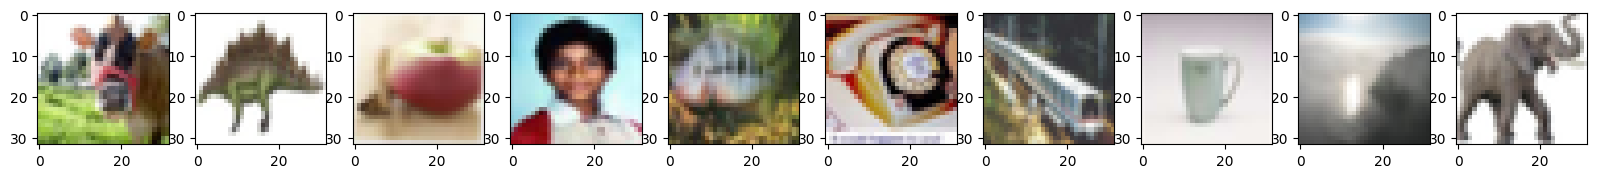

In [17]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20,8))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

In [18]:
#Defining the Input shape 
image_shape = (32, 32, 3) 

dimension = 100


In [19]:
def build_generator(): 
    # Create a sequential model
    model = Sequential() 

    # Building the input layer
    # The input layer is a densely connected layer with 'relu' activation
    model.add(Dense(128 * 8 * 8, activation="relu", input_dim=dimension)) 
    # Reshape the output to a 3D tensor with shape (8, 8, 128)
    model.add(Reshape((8, 8, 128))) 
    
    # Upsample the data
    model.add(UpSampling2D()) 
    
    # Convolutional layer with 128 filters, kernel size 3x3, and 'same' padding
    model.add(Conv2D(128, kernel_size=3, padding="same")) 
    # Batch normalization to normalize and stabilize learning
    model.add(BatchNormalization(momentum=0.78)) 
    # Apply 'relu' activation
    model.add(Activation("relu")) 
    
    # Upsample the data again
    model.add(UpSampling2D()) 
    
    # Convolutional layer with 64 filters, kernel size 3x3, and 'same' padding
    model.add(Conv2D(64, kernel_size=3, padding="same")) 
    # Batch normalization
    model.add(BatchNormalization(momentum=0.78)) 
    # Apply 'relu' activation
    model.add(Activation("relu")) 
    
    # Convolutional layer with 3 filters (output channels), kernel size 3x3, and 'same' padding
    model.add(Conv2D(3, kernel_size=3, padding="same")) 
    # Apply 'tanh' activation to generate pixel values in the range [-1, 1]
    model.add(Activation("tanh")) 

    # Define the input layer for the noise
    noise = Input(shape=(dimension,)) 
    # Generate an image by passing the noise through the model
    image = model(noise) 

    # Return the generator model
    return Model(noise, image)


In [20]:
# Function to build the discriminator model
def build_discriminator(): 
    # Creating a sequential model
    model = Sequential() 
    
    # First convolutional layer
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same")) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dropout(0.25))  # Dropout layer for regularization
    
    # Second convolutional layer
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same")) 
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))  # Zero-padding for spatial dimensions
    model.add(BatchNormalization(momentum=0.82))  # Batch normalization for stable training
    model.add(LeakyReLU(alpha=0.25)) 
    model.add(Dropout(0.25))  # Dropout layer for regularization
    
    # Third convolutional layer
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) 
    model.add(BatchNormalization(momentum=0.82))  # Batch normalization for stable training
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dropout(0.25))  # Dropout layer for regularization
    
    # Fourth convolutional layer
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same")) 
    model.add(BatchNormalization(momentum=0.8))  # Batch normalization for stable training
    model.add(LeakyReLU(alpha=0.25)) 
    model.add(Dropout(0.25))  # Dropout layer for regularization
    
    # Building the output layer 
    model.add(Flatten()) 
    model.add(Dense(1, activation='sigmoid'))  # Dense layer for the output

    # Defining the input layer
    image = Input(shape=image_shape) 
    
    # Obtaining the output from the model
    validity = model(image) 

    # Creating and returning the Model
    return Model(image, validity)


In [21]:
def display_images(): 
        r, c = 5,5
        noise = np.random.normal(0, 1, (r * c,dimension)) 
        generated_images = generator.predict(noise) 

        #Scaling the generated images 
        generated_images = 0.5 * generated_images + 0.5
                    
        fig, axs = plt.subplots(r, c) 
        count = 0
        for i in range(r): 
            for j in range(c): 
                axs[i,j].imshow(generated_images[count, :,:,]) 
                axs[i,j].axis('off') 
                count += 1
        plt.show() 
        plt.close()


In [22]:
# Building and compiling the discriminator 
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', 
					optimizer=Adam(0.0002,0.5), 
					metrics=['accuracy']) 

#Making the Discriminator untrainable 
#so that the generator can learn from fixed gradient 
discriminator.trainable = False

# Building the generator 
generator = build_generator() 

#Defining the input for the generator and generating the images 
dummy = Input(shape=(dimension,)) 
image = generator(dummy) 


#Checking the validity of the generated image 
valid = discriminator(image) 

#Defining the combined model of the Generator and the Discriminator 
combined_network = Model(dummy, valid) 
combined_network.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5)) 


In [23]:
from keras.utils import plot_model
generator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_3 (Sequential)   (None, 32, 32, 3)         1051267   
                                                                 
Total params: 1051267 (4.01 MB)
Trainable params: 1050883 (4.01 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [24]:
from keras.utils import plot_model
discriminator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 1)                 396609    
                                                                 
Total params: 396609 (1.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 396609 (1.51 MB)
_________________________________________________________________


In [25]:
num_epochs=500
batch_size=32
display_after=100
losses=[] 

#Normalizing the input 
x_train = (x_train / 127.5) - 1.

1/1 [==============================] - 0s 98ms/step


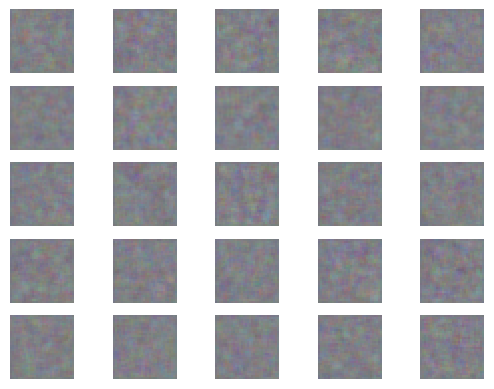

1/1 [==============================] - 0s 56ms/step


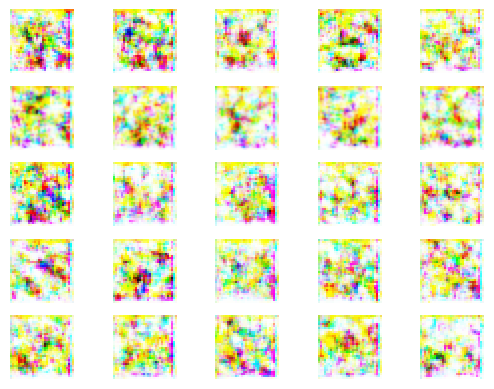

1/1 [==============================] - 0s 56ms/step


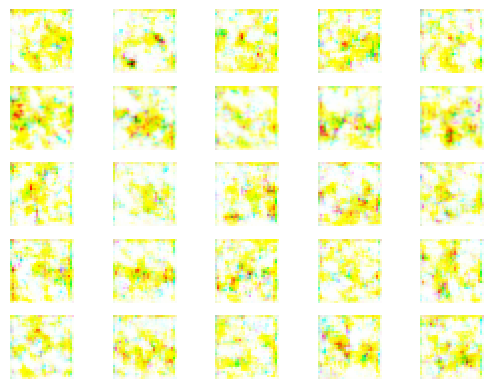

1/1 [==============================] - 0s 188ms/step


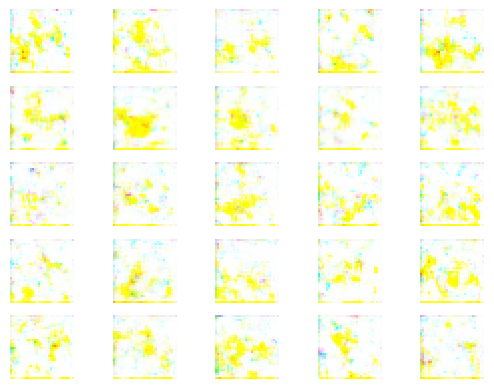

1/1 [==============================] - 0s 64ms/step


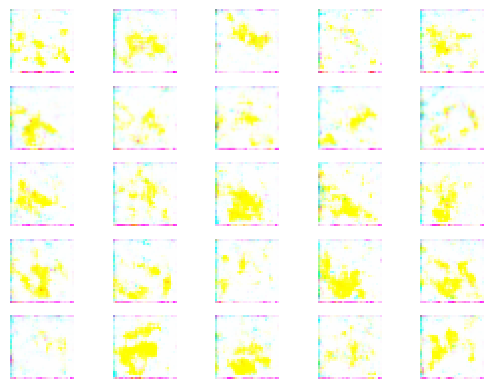

1/1 [==============================] - 0s 66ms/step


In [26]:
#Defining the Adversarial ground truths 
valid = np.ones((batch_size, 1)) 

#Adding some noise 
valid += 0.05 * np.random.random(valid.shape) 
fake = np.zeros((batch_size, 1)) 
fake += 0.05 * np.random.random(fake.shape) 

for epoch in range(num_epochs): 
            
            #Training the Discriminator 
              
            #Sampling a random half of images 
            index = np.random.randint(0, x_train.shape[0], batch_size) 
            images = x_train[index] 

            #Sampling noise and generating a batch of new images 
            noise = np.random.normal(0, 1, (batch_size, dimension)) 
            generated_images = generator.predict(noise) 


            #Training the discriminator to detect more accurately 
            #whether a generated image is real or fake 
            discm_loss_real = discriminator.train_on_batch(images, valid) 
            discm_loss_fake = discriminator.train_on_batch(generated_images, fake) 
            discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake) 
          
            #Training the Generator 
            
            #Training the generator to generate images 
            #which pass the authenticity test 
            genr_loss = combined_network.train_on_batch(noise, valid) 
             
            #Tracking the progress				 
            if epoch % display_after == 0: 
              display_images()
            
       
                

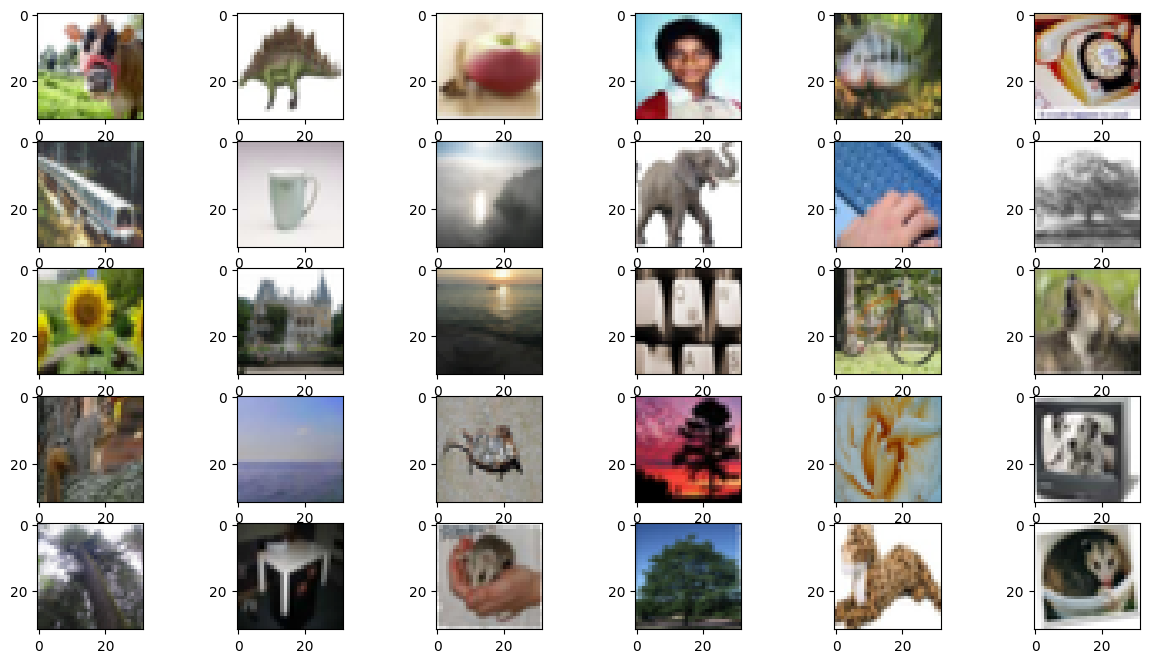

In [27]:
#Plotting some of the original images 
solid = x_train[:30] 
solid = 0.5 * solid + 0.5
f, ax = plt.subplots(5,6, figsize=(15,8)) 
for i, image in enumerate(solid): 
	ax[i//6, i%6].imshow(image) 
	ax[i//6, i%6].axis('on') 
plt.show() 


1/1 [==============================] - 0s 51ms/step


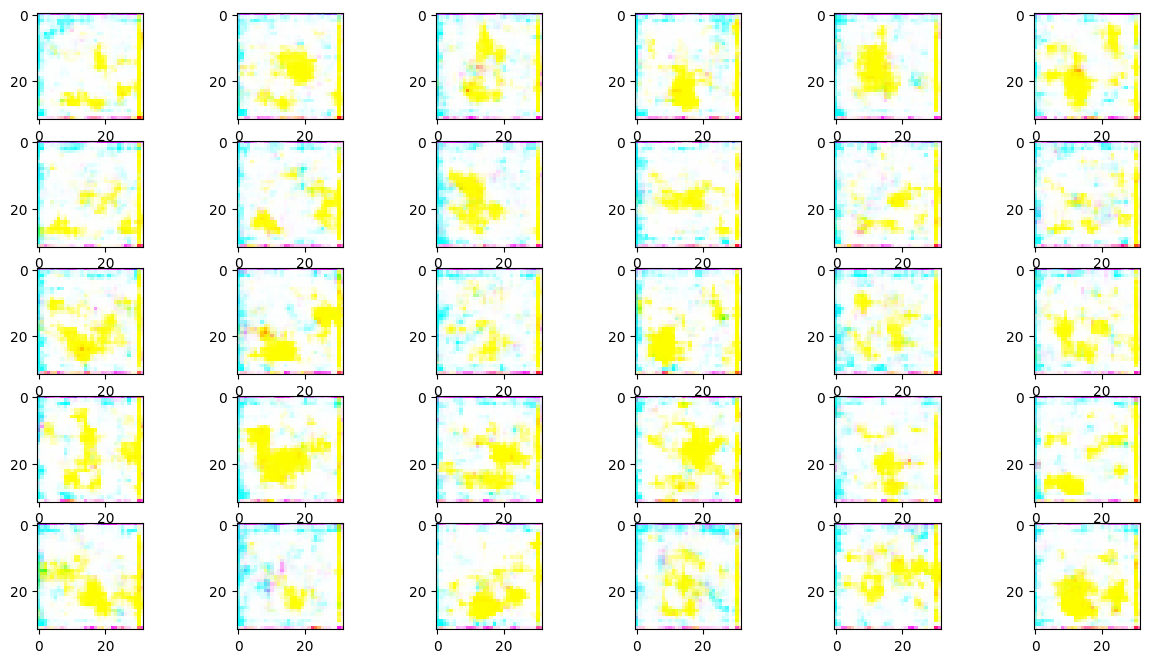

In [28]:
#Plotting some of the last batch of generated images 
noise = np.random.normal(size=(30, dimension)) 
generated_images = generator.predict(noise) 
generated_images = 0.5 * generated_images + 0.5
f, ax = plt.subplots(5,6, figsize=(15,8)) 
for i, image in enumerate(generated_images): 
	ax[i//6, i%6].imshow(image) 
	ax[i//6, i%6].axis('on') 
plt.savefig(f"{num_epochs}-recon.png")
plt.show() 
